# Scheurdetectie op droogtegevoelige dijken

Dit is een voorbeeldnotebook om met een Unet model droogtescheuren op droogtegevoelige dijken te detecteren. Het model is getraind op een verschillende dijken in het beheergebied van HHNK en Wetterskip Fryslan.

# Stel de 'working directory' in
Dit instellen is zodat de relatieve paden tot de scripts en het model goed worden opgepakt door dit notebook.

In [1]:
%cd "../../scripts/scheur-detectie/"

d:\Jeroen\Projects\AI-toolbox-waterkeringen\scripts\scheur-detectie


# Laad de benodigde imports voor dit notebook

In [ ]:
# Imports

import tensorflow as tf
import rasterio as rio
import matplotlib.pyplot as plt
import numpy as np
from rasterio.windows import Window
from rasterio.plot import show
from tensorflow.keras.models import load_model

# Laad het getrainde model in de notebook

Inclusief de tijdens trainen gebruikte 'custom functions' zodat het model geen foutmelding geeft tijdens het voorspellen.

In [3]:
# Model V2 - 2023 with Wetterskip
folds = {4:{'EPOCHS':150,'batch':80,'LR':0.0001}}
fold  =  4    
weights_folder = "saved_weights/model_v2_plateau/" + 'BATCHSIZE_{}_LR_{}_EPOCH_{}_Fold_{}'.\
                    format(folds[fold]['batch'],folds[fold]['LR'],folds[fold]['EPOCHS'],fold)

def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    smooth = 1e-15
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

model = load_model(weights_folder,custom_objects={"dice_loss": dice_loss},compile=False)

# Hieronder een voorbeeld stuk dijk met droogtescheuren

<AxesSubplot: >

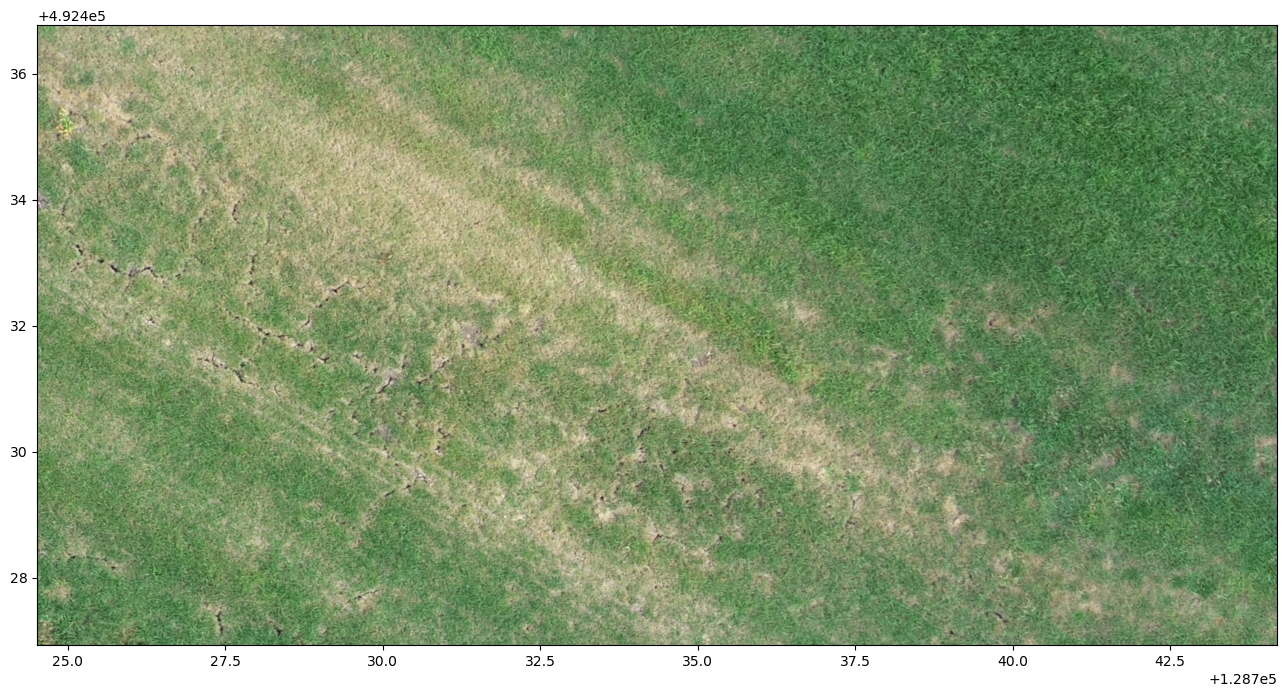

In [4]:
inputfolder = "voorbeeld/"
inputtif = "testfile_cracks_1024x2048.tif"

fig, ax = plt.subplots(1, figsize=(16, 32))
raster_rio = rio.open(inputfolder + inputtif)
show(raster_rio, ax=ax)

# Haal het voorbeeldraster in opgesneden 'windows' door het model heen

Hier wordt door het raster bestand heen 'geloopt' met 'windows' van 256x256 pixels en elke 'window' zal een bijbehorende voorspelling krijgen. Deze voorspellingen zullen naar een nieuw gemaakt raster worden geschreven zodat het eindresultaat een raster met dezelfde afmetingen als het origineel is waarin aangegeven is waar geen scheur (0) en wel een scheur (1) zit.

In [ ]:

# Laad de folders
inputfolder = "voorbeeld/"
inputtif = "testfile_cracks_1024x2048"
extension = ".tif"
labelfolder = "voorbeeld/label/"

file_location = inputfolder + inputtif + extension
label_location = labelfolder + inputtif + "_label" + extension

# Update het originele profiel naar 1 band
raster_file = rio.open(file_location)
profile = raster_file.profile.copy()
profile.update(count=1)

# Maak het bestaand aan
with rio.open(str(label_location), 'w', **profile) as out_file:
    out_file.write(np.zeros([1,1,1]),window=Window.from_slices((0, 1), (0, 1)))

# Totaal aantal windows
total = ((profile['height']-256)/256) * ((profile['width']-256)/256)

# Loop over de windows en voorspel
for idx in range(0,profile['height']-256,256):
    for idy in range(0,profile['width']-256,256):
        print(idx, " of ", total)
        wdw = Window.from_slices((idx, idx+256), (idy, idy+256))

        with rio.open(str(file_location), 'r') as out_file:
            x = out_file.read(window=wdw)

        x = x[:3,:,:]
        x = np.rollaxis(x,0,3)
        
        threshold = 0.8
        
        y_pred = model.predict(np.expand_dims(x/255, axis=0))[0] 
        y_pred_threshold = np.where((y_pred*1000)>(threshold), 1, 0)
        
        with rio.open(str(label_location), 'r+', **profile) as out_file:
            out_file.write(y_pred_threshold.reshape(1,256,256), window=wdw)

0  of  21.0
1/1 [==============================] - 1s 928ms/step
0  of  21.0
1/1 [==============================] - 0s 82ms/step
0  of  21.0
1/1 [==============================] - 0s 83ms/step
0  of  21.0
1/1 [==============================] - 0s 83ms/step
0  of  21.0
1/1 [==============================] - 0s 81ms/step
0  of  21.0
1/1 [==============================] - 0s 80ms/step
0  of  21.0
1/1 [==============================] - 0s 84ms/step
256  of  21.0
1/1 [==============================] - 0s 91ms/step
256  of  21.0
1/1 [==============================] - 0s 88ms/step
256  of  21.0
1/1 [==============================] - 0s 87ms/step
256  of  21.0
1/1 [==============================] - 0s 81ms/step
256  of  21.0
1/1 [==============================] - 0s 82ms/step
256  of  21.0
1/1 [==============================] - 0s 86ms/step
256  of  21.0
1/1 [==============================] - 0s 86ms/step
512  of  21.0
1/1 [==============================] - 0s 86ms/step
512  of  21.0
1/1 [====

# Plot het eindresultaat

Door middel van het laden van het voorspel raster als een 'mask' kan het over het originele stuk dijk heen worden gevisualiseerd waardoor de scheuren worden aangegeven op de dijk.

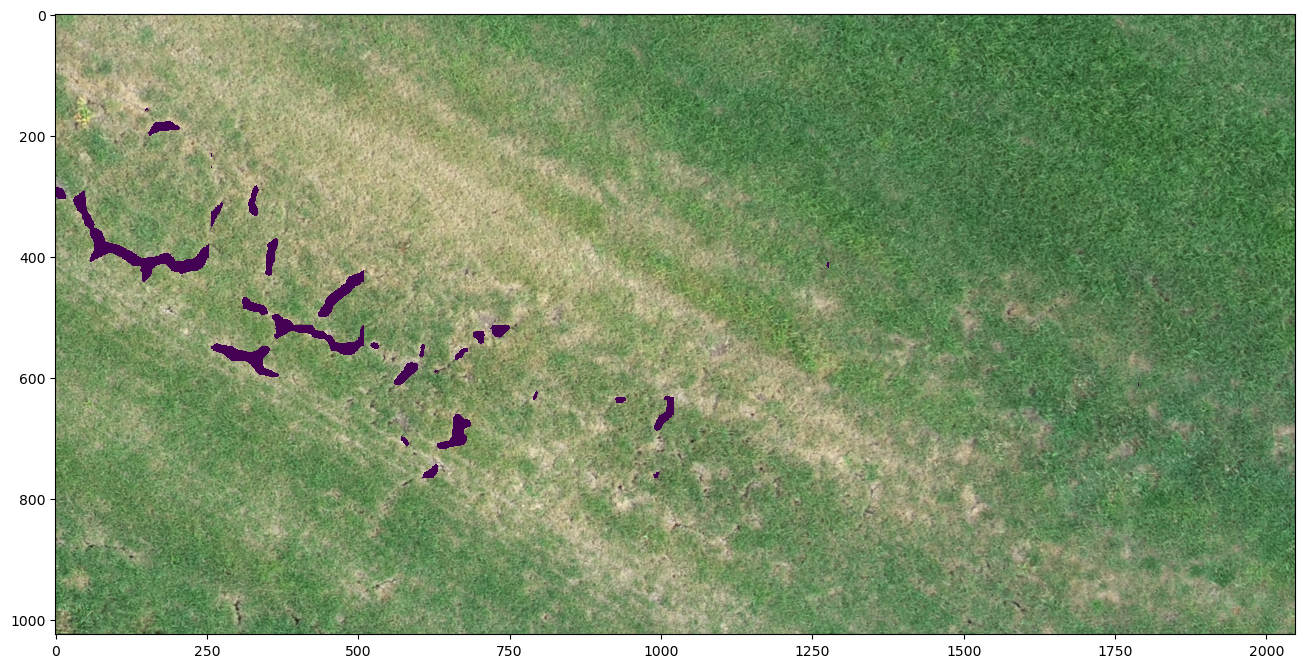

In [ ]:
# Maak een figuur aan
fig, ax = plt.subplots(1, figsize=(16, 32))

# Visualiseer het origineel
inputfolder = "voorbeeld/"
inputtif = "testfile_cracks_1024x2048.tif"

raster_rio = rio.open(inputfolder + inputtif)
raster_array = raster_rio.read()

show(raster_array, ax=ax)

# Visualiseer hieroveer heen het label
inputfolder = "voorbeeld/label/"
inputtif = "testfile_cracks_1024x2048_label.tif"

raster_rio = rio.open(inputfolder + inputtif)
label_array = raster_rio.read()

masked_label = np.ma.masked_where(label_array == 0, label_array)

ax.imshow(masked_label.reshape(1024,2048,1), cmap="viridis")